In [1]:
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/clones/variants_init/knn/kparam_30/donor0/"


In [2]:

import multiprocessing

import pandas as pd
import numpy as np
import random
from deap import base, algorithms
from deap import creator
from deap import tools
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
#matplotlib.rcParams['text.usetex'] = True
from icecream import ic

ic.disable()



In [3]:



from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import mplh.fig_utils as fu

import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from mplh import cluster_help as ch
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.3f')})

from icecream import ic


fig_utils from mplh
0.5.6


In [4]:

# objectives = {ind:x for ind,x in enumerate(objectives_l)}
# weights = np.array(weights)

# assert(len(weights)==len(objectives))
# objectives


# # In[9]:


# param_names = ["pct_thresh","af_thresh", "other_pct_thresh"]
# n_params = 3



In [5]:


# af_indir = join(indir, "sc_af", f"donor{donor}")

# AF_df = pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t")
# DP_df = pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t")

# print(AF_df.shape)
# print(DP_df.shape)
# print("Depth")
# print(DP_df.head())
# AF_df.head()

# cells_meta = pd.read_csv(join(indir, "cells_meta.tsv"), sep='\t', index_col="ID")#.sort_values(["donor", "lineage"])
# cells_meta["name"] = cells_meta["donor"].astype(str)+"_"+cells_meta["lineage"].astype(str)
# # if "donor_index" in cells_meta.columns and "lineage_index" in cells_meta.columns:
# #     cells_meta = cells_meta.sort_values(["donor_index", "lineage_index"])
# #AD_df = pd.merge(AD_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
# curr_labels = cells_meta[cells_meta["donor"]==donor]
# curr_labels

# conditions = curr_labels["condition"].unique()
# conditions


# anno_cells = pd.read_csv(anno_cells_meta_f, sep="\t", index_col=0)


# def rm_high(df, thresh, pct_thresh):
#     return df.loc[~(((df>thresh).sum(axis=1)>pct_thresh*df.shape[0]))]

# def rm_low(df, thresh, pct_thresh):
#     return df.loc[~((df<thresh).sum(axis=1)>(pct_thresh*df.shape[1]))]

#     #return df.loc[~(((df<=thresh).sum(axis=1)>pct_thresh*df.shape[0]))]
# #df[(df<0.01).sum(axis=1)]

# ## Get donor inds
# donor_inds = AF_df.index[((AF_df>0.9).sum(axis=1)>(0.9*AF_df.shape[1]))]
# donor_inds

# Load results

In [6]:
from glob import glob
glob(outdir + "/*csv")

['/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/clones/variants_init/knn/kparam_30/donor0/objectives_norm.csv',
 '/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/clones/variants_init/knn/kparam_30/donor0/objectives.csv',
 '/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/clones/variants_init/knn/kparam_30/donor0/best_params_filt_clone_vars.csv',
 '/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/enriched_barcodes/clones/variants_init/knn/kparam_3

# top 10%

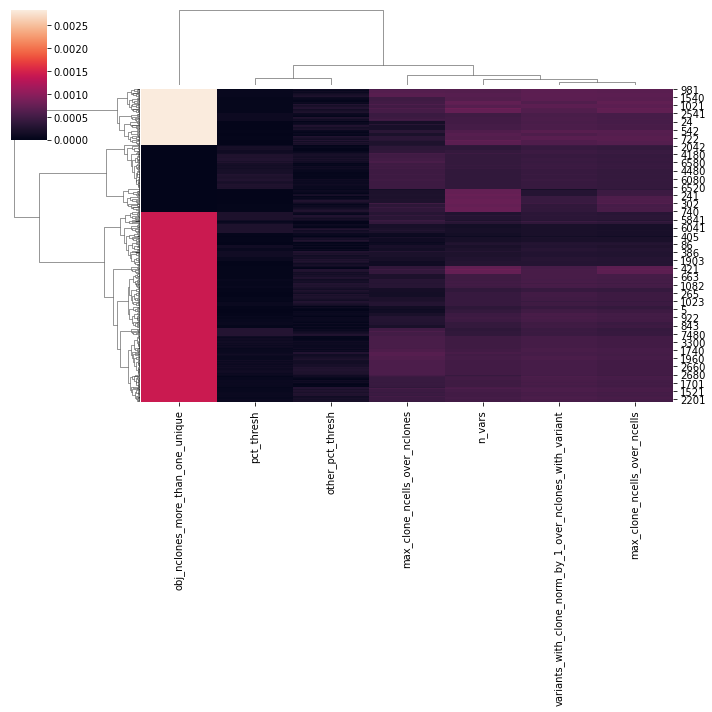

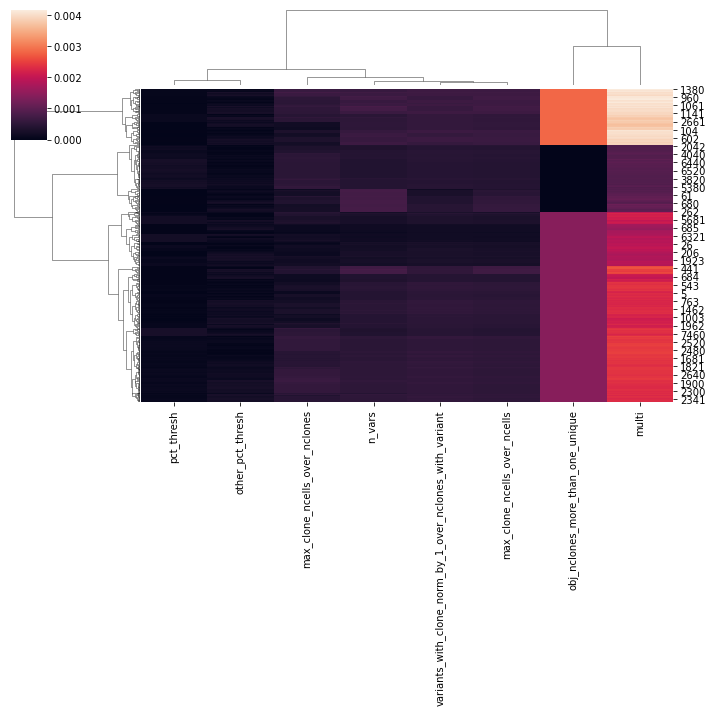

In [7]:
obj_norm_results = pd.read_csv(join(outdir, "objectives_norm.csv"), index_col=0)
obj_results = pd.read_csv(join(outdir, "objectives.csv"), index_col=0)
obj_results = pd.read_csv(join(outdir, "objectives_rank.csv"), index_col=0)
param_results = pd.read_csv(join(outdir, "params.csv"), index_col=0)
obj_results

param_results

param_results.shape

# top 10%

top10perc_n = int(obj_norm_results.shape[0]*0.1)
obj_norm_top10perc = obj_norm_results.iloc[:top10perc_n]
top10perc_n

param_results = param_results.loc[obj_norm_top10perc.index]
# obj_norm_top10perc_params = pd.merge(left=obj_norm_top10perc, right=param_results, left_index=True, right_index=True, how="left", 
#                                      suffixes=["_obj", ""])

sns.clustermap(obj_norm_top10perc.drop("multi", axis=1))

sns.clustermap(obj_norm_top10perc)

## K-means

In [8]:
from dynamicTreeCut import cutreeHybrid
from scipy.spatial.distance import pdist
import numpy as np
from scipy.cluster.hierarchy import linkage
#d = np.transpose(np.arange(1,10001).reshape(100,100))

distances = pdist(obj_norm_top10perc.drop("multi", axis=1).values, "euclidean")
link = linkage(distances, "average")
clusters = cutreeHybrid(link, distances)
# ..cutHeight not given, setting it to 495.1  ===>  99% of the (truncated) height range in dendro.
# ..done.
clusters["labels"]
clusters["ID"] = obj_norm_top10perc.index
clusters = pd.DataFrame({"ID":clusters["ID"], "labels": clusters["labels"]}, index=obj_norm_top10perc.index)#[["ID", "labels"]]
clusters

..cutHeight not given, setting it to 0.0018354335356670502  ===>  99% of the (truncated) height range in dendro.
..done.


,ID,labels
840,840,2
1240,1240,2
860,860,2
821,821,2
1260,1260,2
...,...,...
6240,6240,4
5360,5360,4
5820,5820,4
4940,4940,4


In [9]:
param_results = pd.merge(clusters, param_results, left_index=True, right_index=True, how="inner")
param_results

,ID,labels,pct_thresh,other_pct_thresh,af_thresh
840,840,2,0.15,0.105,0.005
1240,1240,2,0.20,0.105,0.005
860,860,2,0.15,0.155,0.005
821,821,2,0.15,0.055,0.055
1260,1260,2,0.20,0.155,0.005
...,...,...,...,...,...
6240,6240,4,0.80,0.605,0.005
5360,5360,4,0.70,0.405,0.005
5820,5820,4,0.75,0.555,0.005
4940,4940,4,0.65,0.355,0.005


In [10]:
param_results.shape

(730, 5)

In [11]:
param_results.groupby("labels").mean()

,ID,pct_thresh,other_pct_thresh,af_thresh
labels,,,,
1,1912.452830,0.263522,0.511918,0.080472
2,1001.290076,0.149618,0.511870,0.084771
3,2893.023810,0.388492,0.460556,0.148254
4,5211.166667,0.686275,0.306961,0.014314
5,317.566038,0.066981,0.456887,0.053113


In [12]:
from mplh import cluster_help as ch

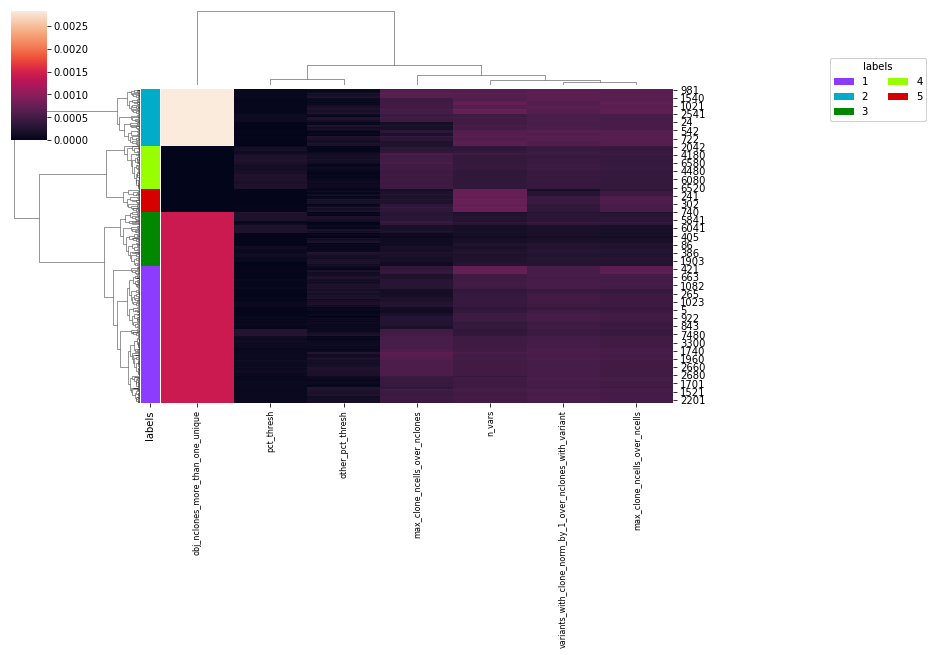

In [13]:
ch.plot_cluster(obj_norm_top10perc.drop("multi", axis=1), row_meta=clusters[["labels"]])

## Get average parameters for each cluster .  run unique over these

In [19]:
top_params_mean_df = param_results.groupby("labels").mean().drop("ID", axis=1)
top_params_mean_df

,pct_thresh,other_pct_thresh,af_thresh
labels,,,
1,0.263522,0.511918,0.080472
2,0.149618,0.511870,0.084771
3,0.388492,0.460556,0.148254
4,0.686275,0.306961,0.014314
5,0.066981,0.456887,0.053113


In [ ]:
af_indir = join(indir, "sc_af", f"donor{donor}")

AF_df = pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t")
DP_df = pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t")

print(AF_df.shape)
print(DP_df.shape)
print("Depth")
print(DP_df.head())
AF_df.head()

cells_meta = pd.read_csv(join(indir, "cells_meta.tsv"), sep='\t', index_col="ID")#.sort_values(["donor", "lineage"])
cells_meta["name"] = cells_meta["donor"].astype(str)+"_"+cells_meta["lineage"].astype(str)
# if "donor_index" in cells_meta.columns and "lineage_index" in cells_meta.columns:
#     cells_meta = cells_meta.sort_values(["donor_index", "lineage_index"])
#AD_df = pd.merge(AD_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
curr_labels = cells_meta[cells_meta["donor"]==donor]
curr_labels

conditions = curr_labels["condition"].unique()
conditions


anno_cells = pd.read_csv(anno_cells_meta_f, sep="\t", index_col=0)


def rm_high(df, thresh, pct_thresh):
    return df.loc[~(((df>thresh).sum(axis=1)>pct_thresh*df.shape[0]))]

def rm_low(df, thresh, pct_thresh):
    return df.loc[~((df<thresh).sum(axis=1)>(pct_thresh*df.shape[1]))]

    #return df.loc[~(((df<=thresh).sum(axis=1)>pct_thresh*df.shape[0]))]
#df[(df<0.01).sum(axis=1)]

## Get donor inds
donor_inds = AF_df.index[((AF_df>0.9).sum(axis=1)>(0.9*AF_df.shape[1]))]
donor_inds

In [ ]:
all_df = []
all_objs = {}
for ind, val in filt_results.iterrows():
    print(ind)
    obj_out, data = evaluate_series(val, AF_df, DP_df, curr_labels, return_data=True)
    all_df.append(data["all_unique_df"])
    all_objs[ind] = obj_out 
all_df = pd.concat(all_df)

## Flatten unique variants and correlate?